In [76]:
import time
from pynput import mouse # type: ignore
from pynput.mouse import Button, Controller # type: ignore
from PIL import ImageGrab
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import sys
import matplotlib.pyplot as plt
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
import cv2
import pandas as pd


In [61]:
def chargerImage(image_url):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    return image


def draw_line(tupleCoordonnees, initialCoordonate):
    mouse = Controller()
    x1 = tupleCoordonnees[0][0] + initialCoordonate[0]
    x2 = tupleCoordonnees[1][0] + initialCoordonate[0]

    y1 = tupleCoordonnees[0][1] + initialCoordonate[1]
    y2 = tupleCoordonnees[1][1] + initialCoordonate[1]

    mouse.position = (x1, y1)
    time.sleep(0.005)
    mouse.press(Button.left)
    mouse.position = (x2, y2)
    time.sleep(0.005)
    mouse.release(Button.left)

def dessiner(initalCoordonate, listeDessin,positionCouleur ):
    mouse = Controller()
    mouse.position = positionCouleur
    time.sleep(1)
    mouse.click(Button.left, 1)

    for trait in listeDessin:
        draw_line(trait, initalCoordonate)
    return

def recupererCouleurPixel(x,y,couleurs):
    img = ImageGrab.grab(bbox=(int(x), int(y), int(x + 1), int(y +1)))
    couleurs.append(np.array(img.getpixel((0, 0)))[:3])

def couleurPlusProche(colorColor, pixel):
    distancePlusPetite = 10000
    couleurRemplacement = (0,0,0)

    for color in colorColor:
        if np.all(pixel == color):
            return color
        else:
            distance = np.linalg.norm(np.array(pixel) - np.array(color))
            if distance < distancePlusPetite:
                couleurRemplacement = color
                distancePlusPetite = distance

    return couleurRemplacement

def changerCouleur(colorColor, pixels):
    colorColor = np.array(colorColor)
    shape = pixels.shape
    pixels_flat = pixels.reshape(-1, pixels.shape[-1])

    for i in range(pixels_flat.shape[0]):
        pixel = pixels_flat[i][:3]
        pixels_flat[i][:3] = couleurPlusProche(colorColor, pixel)

    return pixels.reshape(shape)

def changerCouleur2(couleurs, pixels):
    for i in range(len(pixels)):
        for j in range(len(pixels[0])):
            pixel = pixels[i][j]
            if np.all(pixel == [255, 255, 255]):
                continue
            pixels[i][j] = couleurPlusProche(couleurs, pixel)

def recurerPaletteCouleurs(positionsCouleurs, nbCouleurs, couleurs):
    def getColor(x, y, button, pressed):
        if pressed and len(positionsCouleurs) < nbCouleurs:
            positionsCouleurs.append((int(x), int(y)))
            recupererCouleurPixel(x, y, couleurs)
            if len(positionsCouleurs) == nbCouleurs:
                return False
    with mouse.Listener(on_click=getColor) as listener:
        listener.join()
    print("Fin de la selection de la palette de couleurs.")


def recupererCoinsGrille(positionsCoins):
    def getGrid(x, y, button, pressed):
        if pressed and len(positionsCoins) < 2:
            positionsCoins.append((int(x), int(y)))
            if len(positionsCoins) == 2:
                return False  # Stop listener when enough points are selected

    with mouse.Listener(on_click=getGrid) as listener:
        listener.join()
    print("Fin de la selection de la grille.")
    print("Positions grille:", positionsCoins)



def calculerDimensionsGrille(positionsCoins):
    largeur = abs(positionsCoins[0][0] - positionsCoins[1][0])
    hauteur = abs(positionsCoins[0][1] - positionsCoins[1][1])
    return largeur, hauteur


def generateMatricesCouleurs(couleurs, pixels):
    matricesCouleurs = []
    for couleur in couleurs:
        matrice = np.zeros((pixels.shape[0], pixels.shape[1]))
        for i in range (len(pixels)):
            for j in range(pixels.shape[1]):
                if np.any(pixels[i][j] == couleur):
                    matrice[i][j] = 1
        matricesCouleurs.append(matrice)
    return matricesCouleurs


def ajouterColonnes0(matrices):
    colonne_zero = np.zeros((matrices[0].shape[0], 1))
    for i in range (len(matrices)):
        matrices[i] = np.hstack((matrices[i], colonne_zero))
        matrices[i] = np.hstack((colonne_zero,matrices[i]))
    return matrices



def calculGradientMatrices(matrices):
    matricesGradient = []
    for matrice in matrices : 
        gradient = np.zeros_like(matrice)
        print(matrice.shape)
        for i in range (0, matrice.shape[1]-1):
            gradient[:,i] = np.abs(matrice[:,i+1] - matrice[:,i])
        print(gradient)
        matricesGradient.append(gradient)
    return matricesGradient


def calculListesDessin(matricesGradient):
    listesDessin = []
    for matrice in matricesGradient:
        listeDessin = []
        for i in range(len(matrice)):
            line = []
            for j in range(len(matrice[0])):
                if matrice[i][j] == 1 and len(line) == 0:
                    line.append([j,i])
                elif matrice[i][j] == 1 and len(line) == 1:
                    line.append([j,i])
                    listeDessin.append((line[0],line[1]))
                    line = []
        listesDessin.append(listeDessin)
    return listesDessin


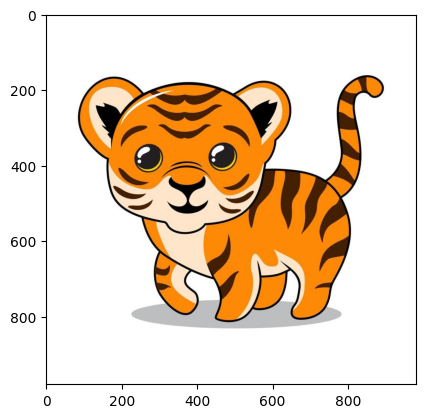

In [90]:
url = input("Entrez l'URL de l'image: ")
image = chargerImage(url)
image.load()
image2 = Image.new('RGB', image.size, (255, 255, 255))
image2.paste(image, None)
plt.imshow(image2)


In [92]:
nbCouleur = 6
print("Selectionnez les couleurs de la palette.")
positionsCouleurs = []
couleurs = []
recurerPaletteCouleurs(positionsCouleurs, nbCouleur, couleurs)


Selectionnez les couleurs de la palette.
Fin de la selection de la palette de couleurs.


Couleurs selectionnees:  [[0.65490196 0.45098039 0.18823529]
 [0.93333333 0.50196078 0.25098039]
 [0.94901961 0.69803922 0.66666667]
 [1.         1.         1.        ]
 [0.         0.         0.        ]
 [0.65490196 0.45098039 0.18823529]]


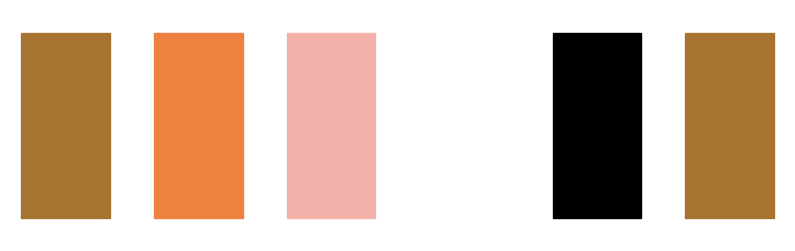

In [93]:
couleurs_matplot = np.array(couleurs)
couleurs_matplot = couleurs_matplot / 255.0

print("Couleurs selectionnees: ", couleurs_matplot)
fig, axs = plt.subplots(1, len(couleurs_matplot), figsize=(10, 3))

# Afficher des carrés de couleur sur chaque subplot
for ax, couleur in zip(axs, couleurs_matplot):
    ax.add_patch(plt.Rectangle((0.1, 0.1), 0.8, 0.8, color=couleur))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')  # Pour ne pas afficher les axes
plt.show()

Transformation de l'image en tableau de pixels.
Changement des couleurs des pixels.


(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

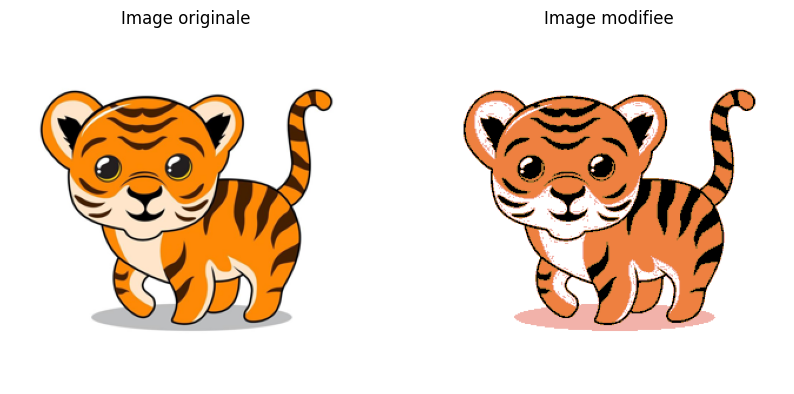

In [94]:
print("Transformation de l'image en tableau de pixels.")
image2 = image2.resize((300,300))
pixels = np.array(image2)


print("Changement des couleurs des pixels.")
changerCouleur2(couleurs, pixels)



fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(image2)
axes[0].set_title('Image originale')
axes[0].axis('off')

axes[1].imshow(pixels)
axes[1].set_title('Image modifiee')
axes[1].axis('off')


Transformation de l'image en tableau de pixels.
Changement des couleurs des pixels.


(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

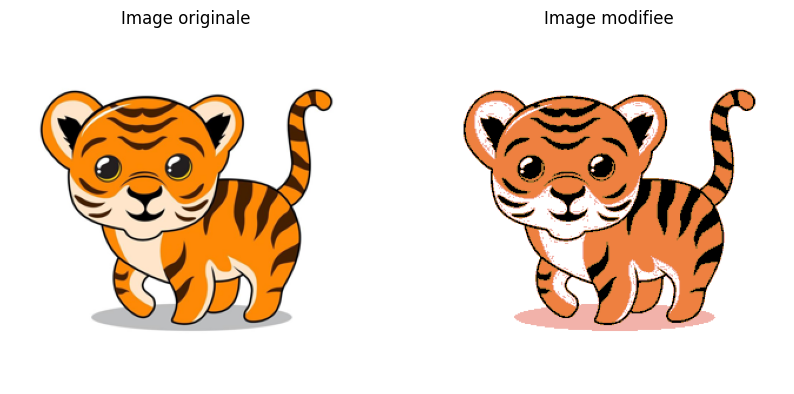

In [95]:
print("Transformation de l'image en tableau de pixels.")
#image2 = image2.resize((50,20))
pixels = np.array(image2)


print("Changement des couleurs des pixels.")
changerCouleur(couleurs, pixels)



fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(image2)
axes[0].set_title('Image originale')
axes[0].axis('off')

axes[1].imshow(pixels)
axes[1].set_title('Image modifiee')
axes[1].axis('off')


In [80]:
pixels_reshaped = pixels.reshape(-1, 3)
pixels_tuples = [tuple(pixel) for pixel in pixels_reshaped]

# Compter les occurrences de chaque couleur unique
pixels_series = pd.Series(pixels_tuples)
occurrences = pixels_series.value_counts()

print("Occurrences des couleurs:")
print(occurrences)

Occurrences des couleurs:
(255, 255, 255)    629865
(246, 195, 77)     220414
(0, 0, 0)           48404
(81, 173, 76)       28785
(167, 115, 48)      27482
(140, 26, 17)       13668
(140, 70, 32)       12894
(234, 51, 42)        8029
(238, 128, 64)       2572
(189, 97, 91)        2539
(102, 102, 102)      1488
(49, 114, 45)        1449
(242, 178, 170)      1303
(170, 170, 170)      1086
(140, 26, 77)          22
Name: count, dtype: int64


Elimination des couleurs peu frequentes.
Couleurs selectionnees:  [[1.         1.         1.        ]
 [0.96470588 0.76470588 0.30196078]
 [0.         0.         0.        ]
 [0.31764706 0.67843137 0.29803922]
 [0.65490196 0.45098039 0.18823529]
 [0.54901961 0.10196078 0.06666667]
 [0.54901961 0.2745098  0.1254902 ]]


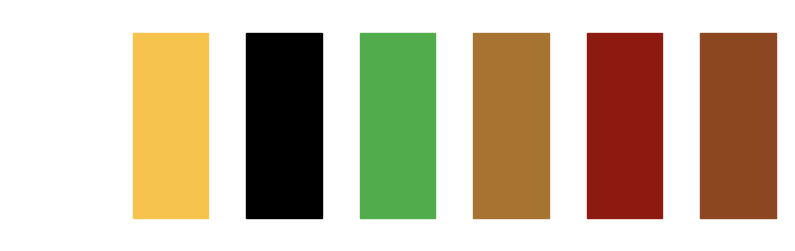

In [83]:
print("Elimination des couleurs peu frequentes.")
# Eliminer les couleurs peu fréquentes
seuil = 0.01
occurrences = occurrences[occurrences > seuil * len(pixels_tuples)]
couleurs_matplot = occurrences.index.tolist()
couleurs_matplot = np.array(couleurs_matplot)  / 255.0

print("Couleurs selectionnees: ", couleurs_matplot)
fig, axs = plt.subplots(1, len(couleurs_matplot), figsize=(10, 3))

# Afficher des carrés de couleur sur chaque subplot
for ax, couleur in zip(axs, couleurs_matplot):
    ax.add_patch(plt.Rectangle((0.1, 0.1), 0.8, 0.8, color=couleur))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')  # Pour ne pas afficher les axes

In [84]:
print("Affichage de l'image dans la nouvelle palette de couleurs.")



Affichage de l'image dans la nouvelle palette de couleurs.
